In [32]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

import torch, torchvision
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim import lr_scheduler

%matplotlib inline
%config InlineBackend.figure_format='retina'

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F0\
0FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataset is german traffic sign recognition benchmark

In [2]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-10-15 14:32:18--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  4.33MB/s    in 40m 47s 

2020-10-15 15:13:10 (110 KB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [3]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [4]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')

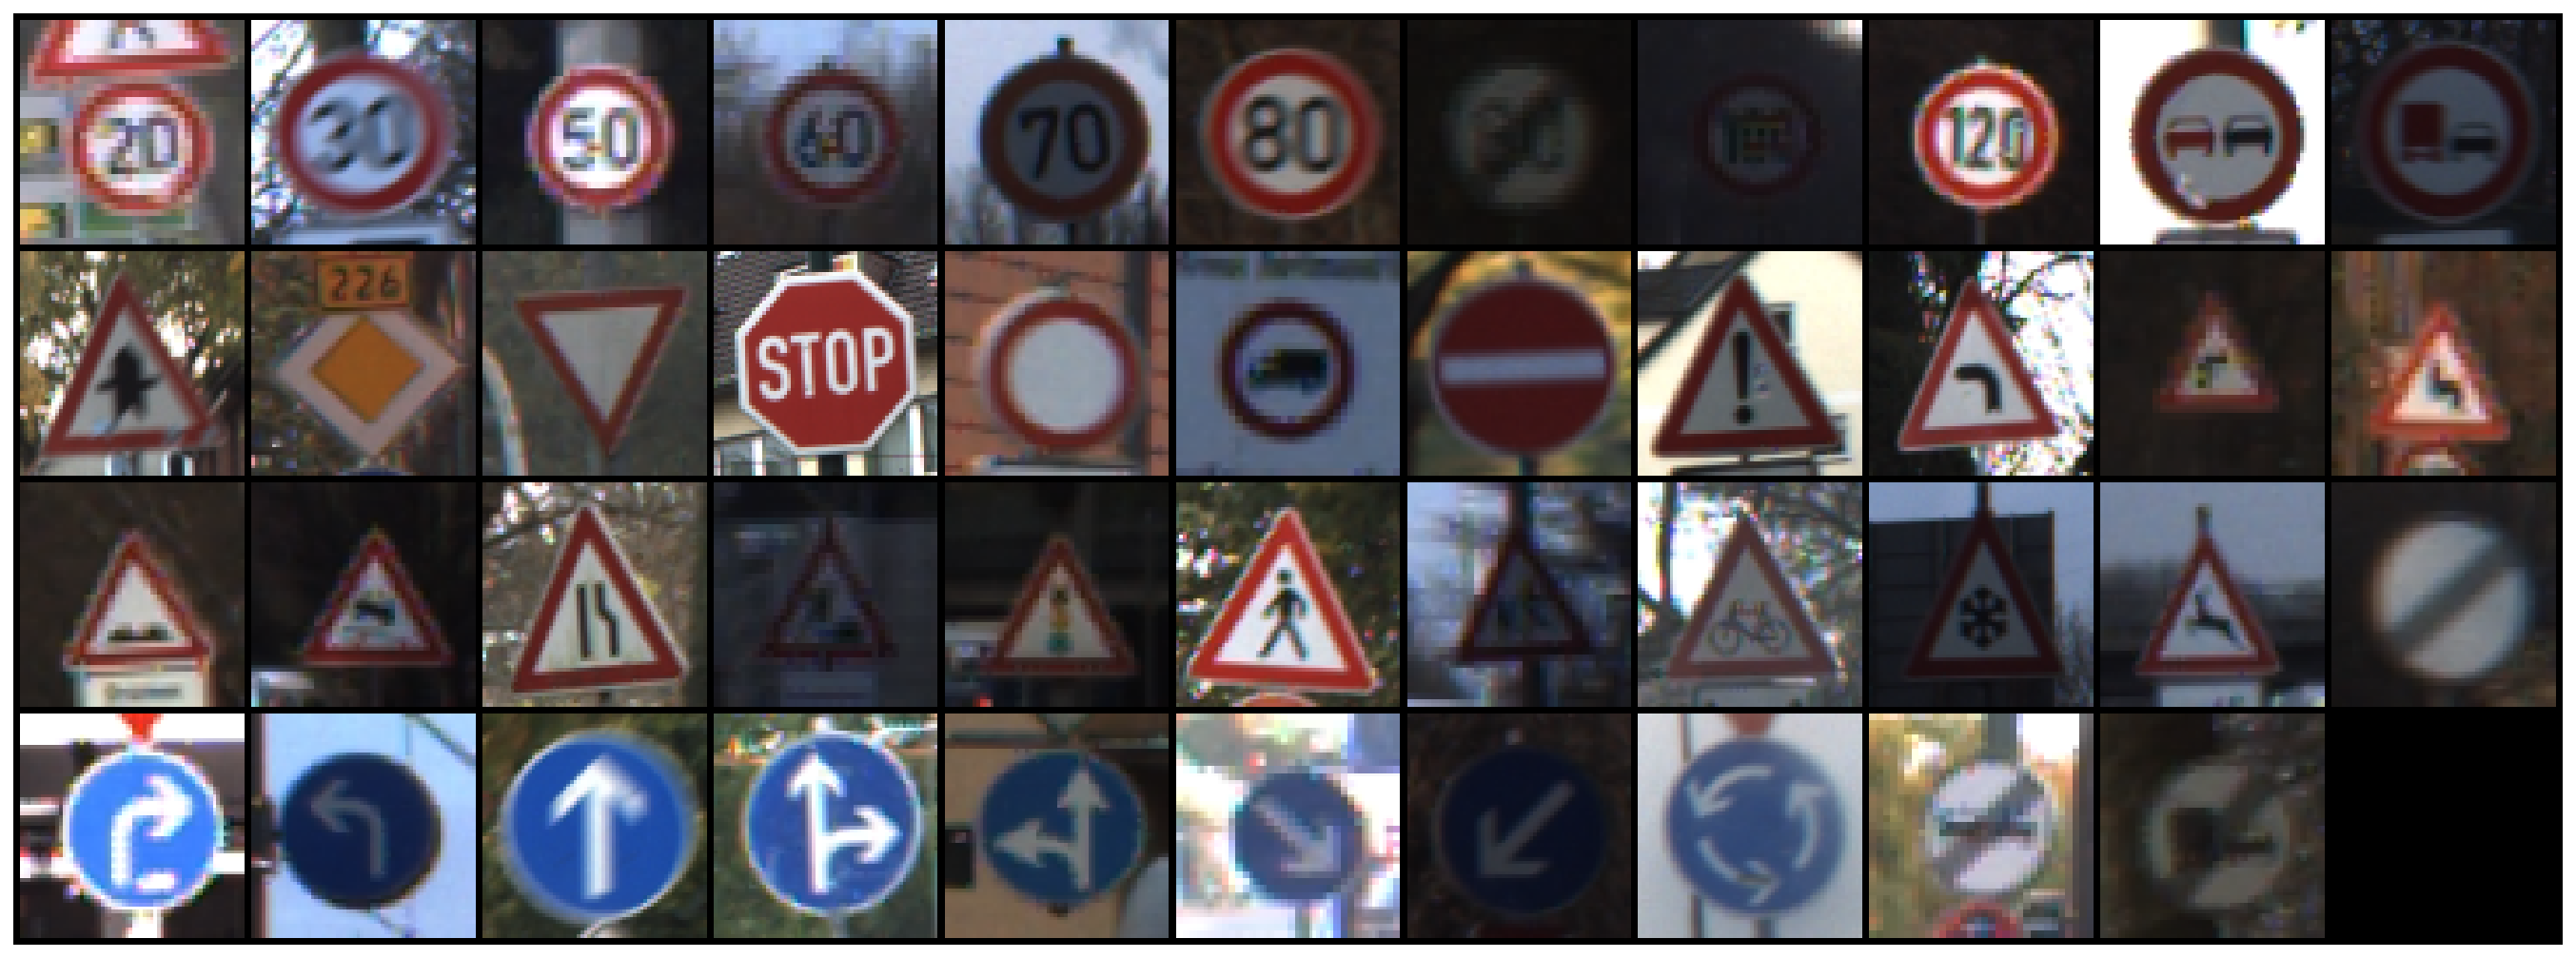

In [5]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders ]
show_sign_grid(sample_images)

### Time to build the dataset (We will only take the most used traffic signs)

In [6]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12,13,14,17]

In [7]:
!rm -rf data

In [8]:
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds/ cls).mkdir(parents=True, exist_ok=True)

In [10]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*ppm'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)
    
    ds_split = np.split(image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))])
    dataset_data = zip(DATASETS, ds_split)
    
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


### Data augmentation to increase data size

In [13]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

In [15]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
    for d in DATASETS
}

In [16]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

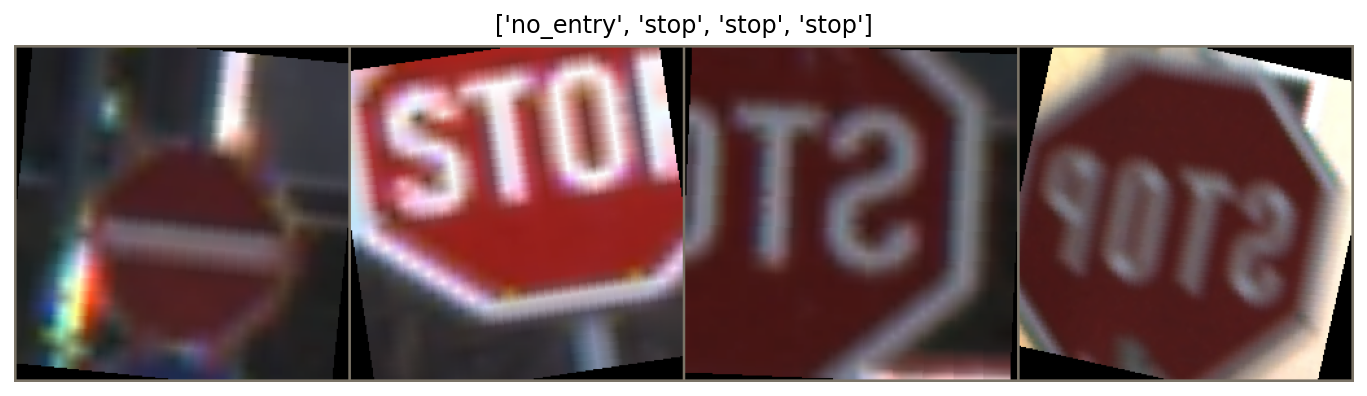

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Use pretrained resnet34 model to classify the images

We are going to use the weights of the resnet model and just change the output layer as the number of classes we have is different from ImageNet

In [26]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True, progress=False)
    
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)
    
    return model.to(device)

In [27]:
base_model = create_model(len(class_names))

Exception ignored in: <function tqdm.__del__ at 0x7f74dea3ef80>
Traceback (most recent call last):
  File "/home/fadil/anaconda3/envs/ML2/lib/python3.7/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/fadil/anaconda3/envs/ML2/lib/python3.7/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/fadil/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [36]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train'])
        print(f'Train loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            
        
        print(f'Best val accuracy: {best_accuracy}')
        model.load_state_dict(torch.load('best_model_state.bin'))
        
    return model, history

In [39]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.15849155976278026 accuracy 0.949390243902439
Val loss 0.022283565236861036 accuracy 0.9902439024390244

Best val accuracy: 0.9902439024390244
Epoch 2/3
----------
Train loss 0.07981868216661903 accuracy 0.973170731707317
Val loss 0.0008222440104424544 accuracy 1.0

Best val accuracy: 1.0
Epoch 3/3
----------
Train loss 0.07265693109209945 accuracy 0.9782520325203252
Val loss 0.0023781386934116472 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 3min 36s, sys: 6.2 s, total: 3min 43s
Wall time: 3min 46s


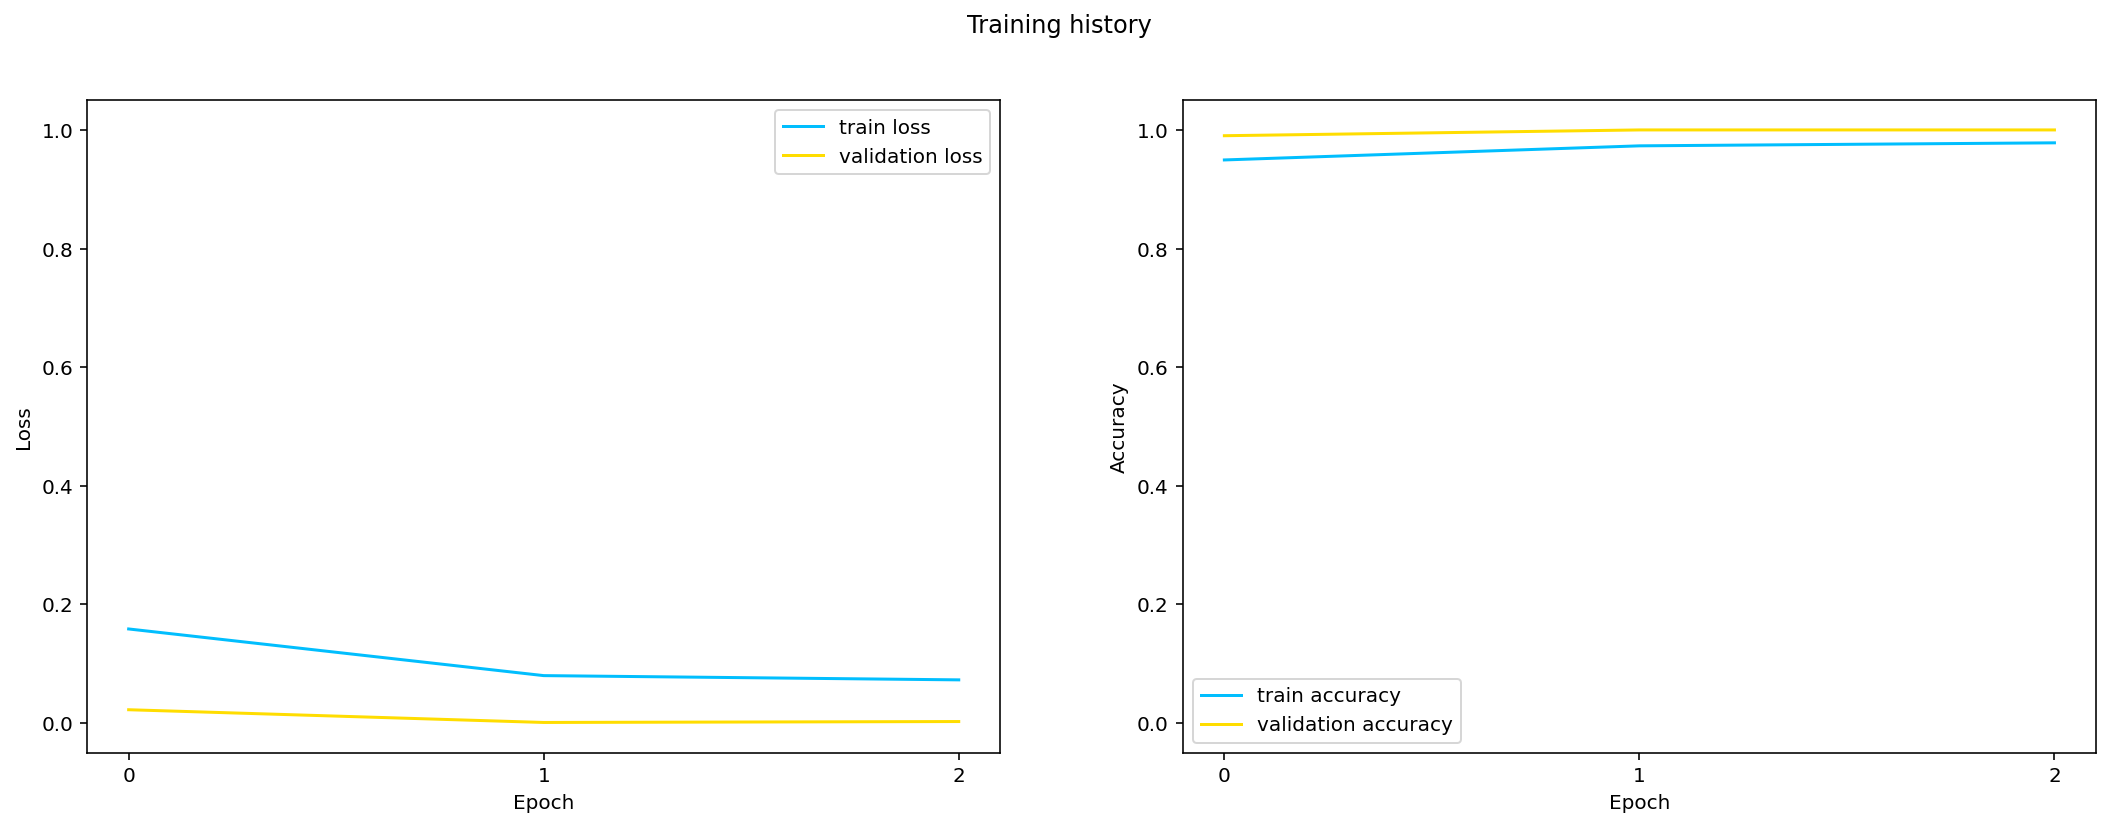

In [40]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])

    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')
    
plot_training_history(history)

### Evaluation

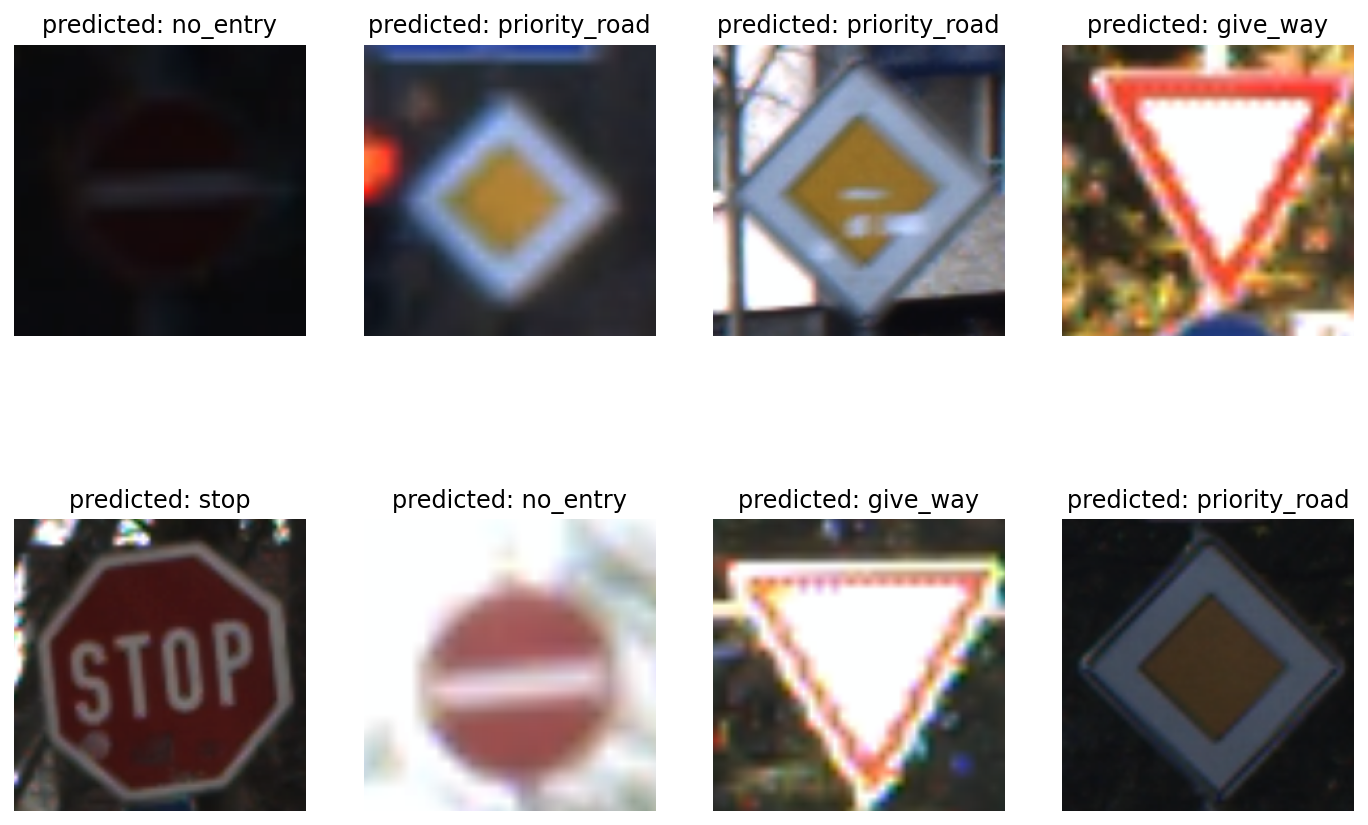

In [41]:
def show_predictions(model, class_names, n_images=0):
    model = model.eval()
    images_handeled = 0
    plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _,preds = torch.max(outputs, 1)
            
            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')
                
                if images_handeled == n_images:
                    return
                
show_predictions(base_model, class_names, n_images=8)

In [44]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
            
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    
    return predictions, real_values
            
y_pred, y_test = get_predictions(base_model, data_loaders['test'])          

In [45]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



In [47]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /home/fadil/Documents/fun_projects/pytorch/pytorch-transfer-learning-image-classifier/stop-sign.jpg
100%|███████████████████████████████████████| 77.3k/77.3k [00:00<00:00, 550kB/s]


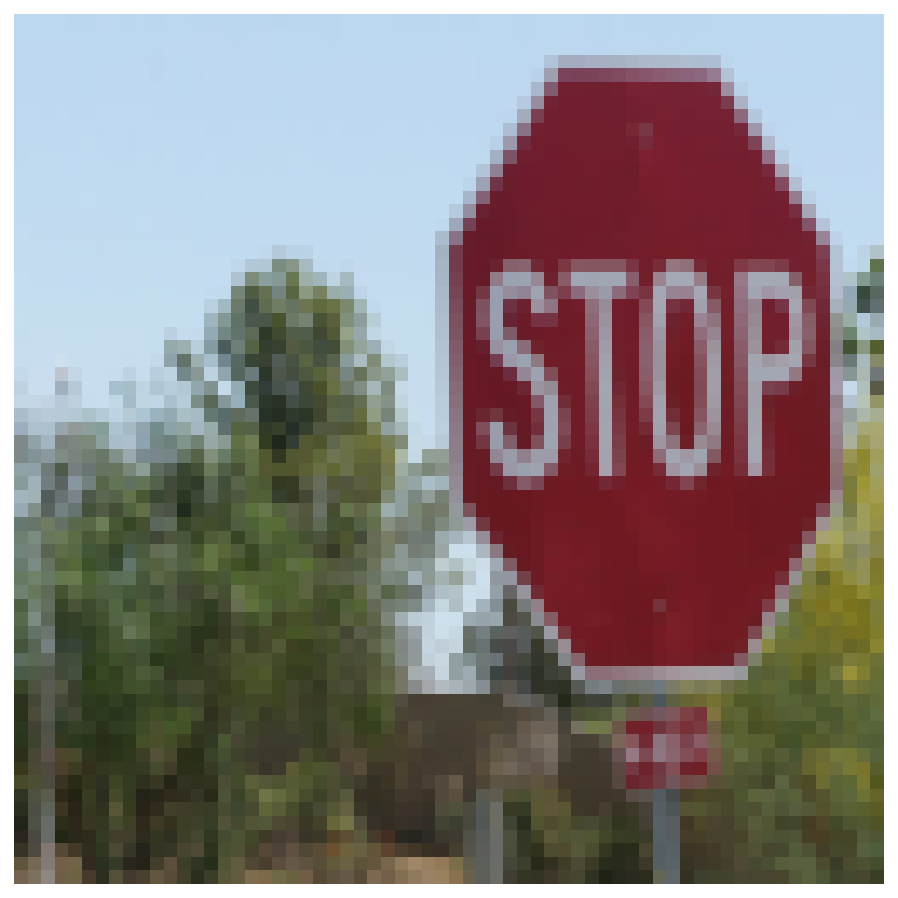

In [48]:
show_image('stop-sign.jpg')

In [49]:
def predict_proba(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = transforms['test'](img).unsqueeze(0)
    
    pred = model(img.to(device))
    pred = F.softmax(pred, dim=1)
    return pred.detach().cpu().numpy().flatten()

In [50]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([0.0132475 , 0.04249591, 0.01558796, 0.9286686 ], dtype=float32)

In [51]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1]);

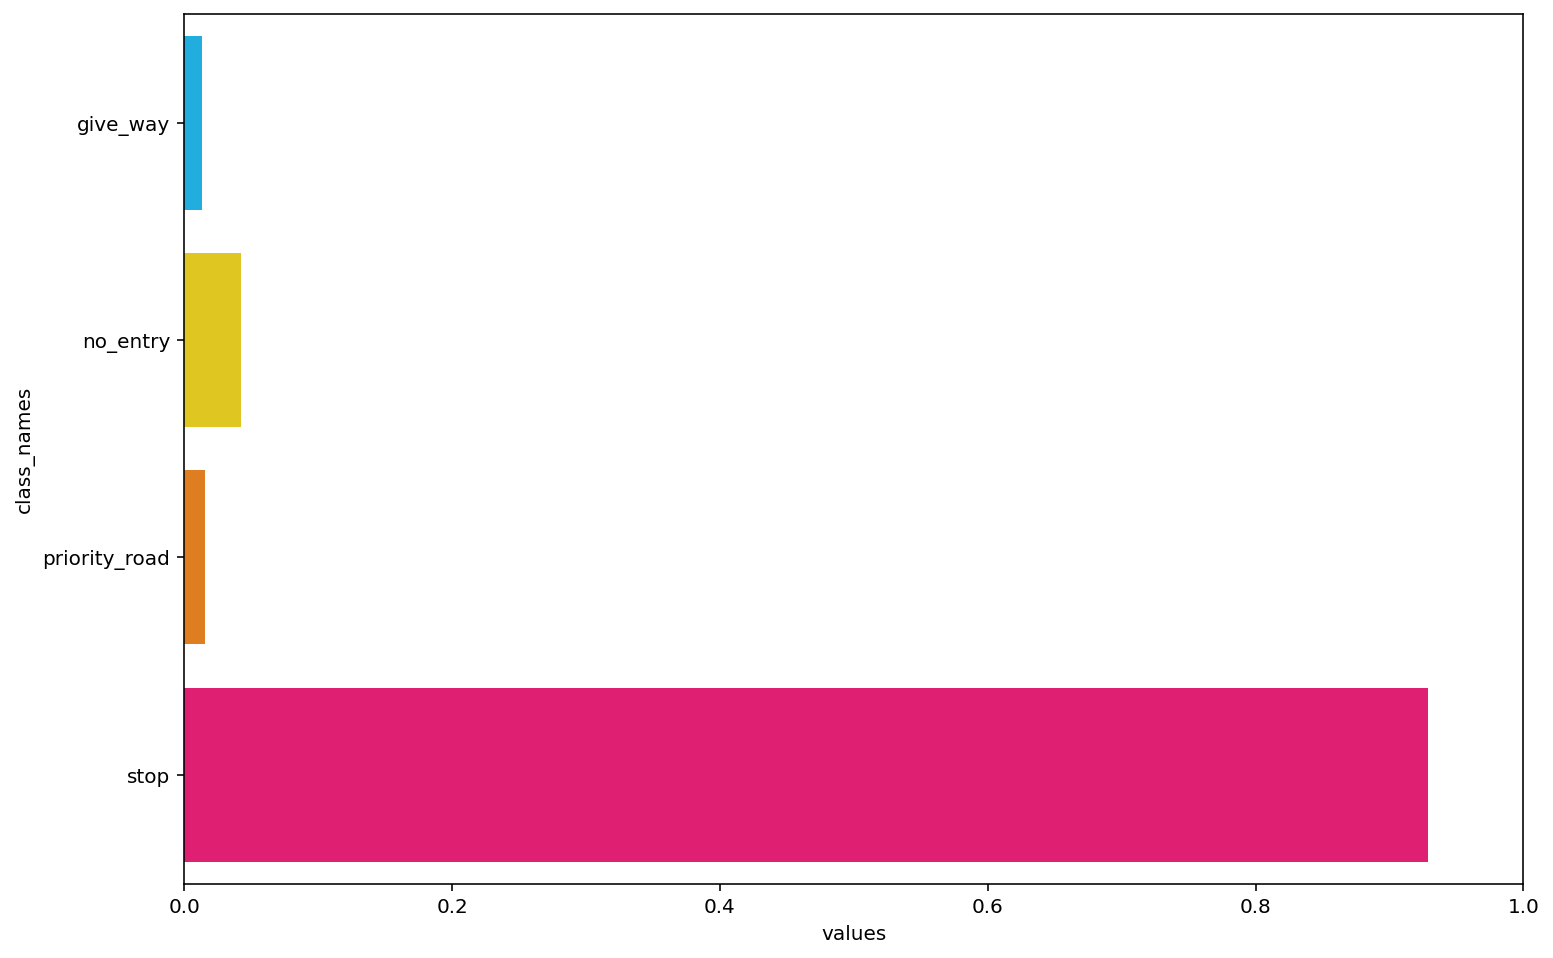

In [52]:
show_prediction_confidence(pred, class_names)

### Predicting unknown signs

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /home/fadil/Documents/fun_projects/pytorch/pytorch-transfer-learning-image-classifier/unknown-sign.jpg
100%|██████████████████████████████████████| 41.4k/41.4k [00:00<00:00, 34.2MB/s]


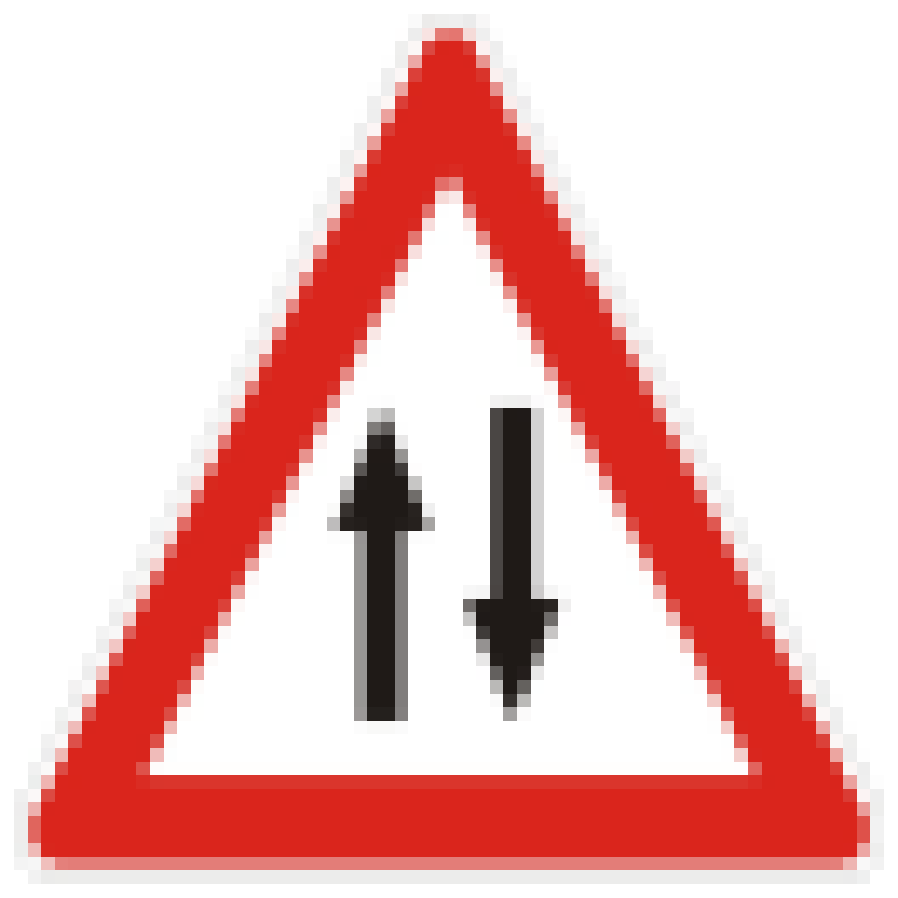

In [53]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
show_image('unknown-sign.jpg')

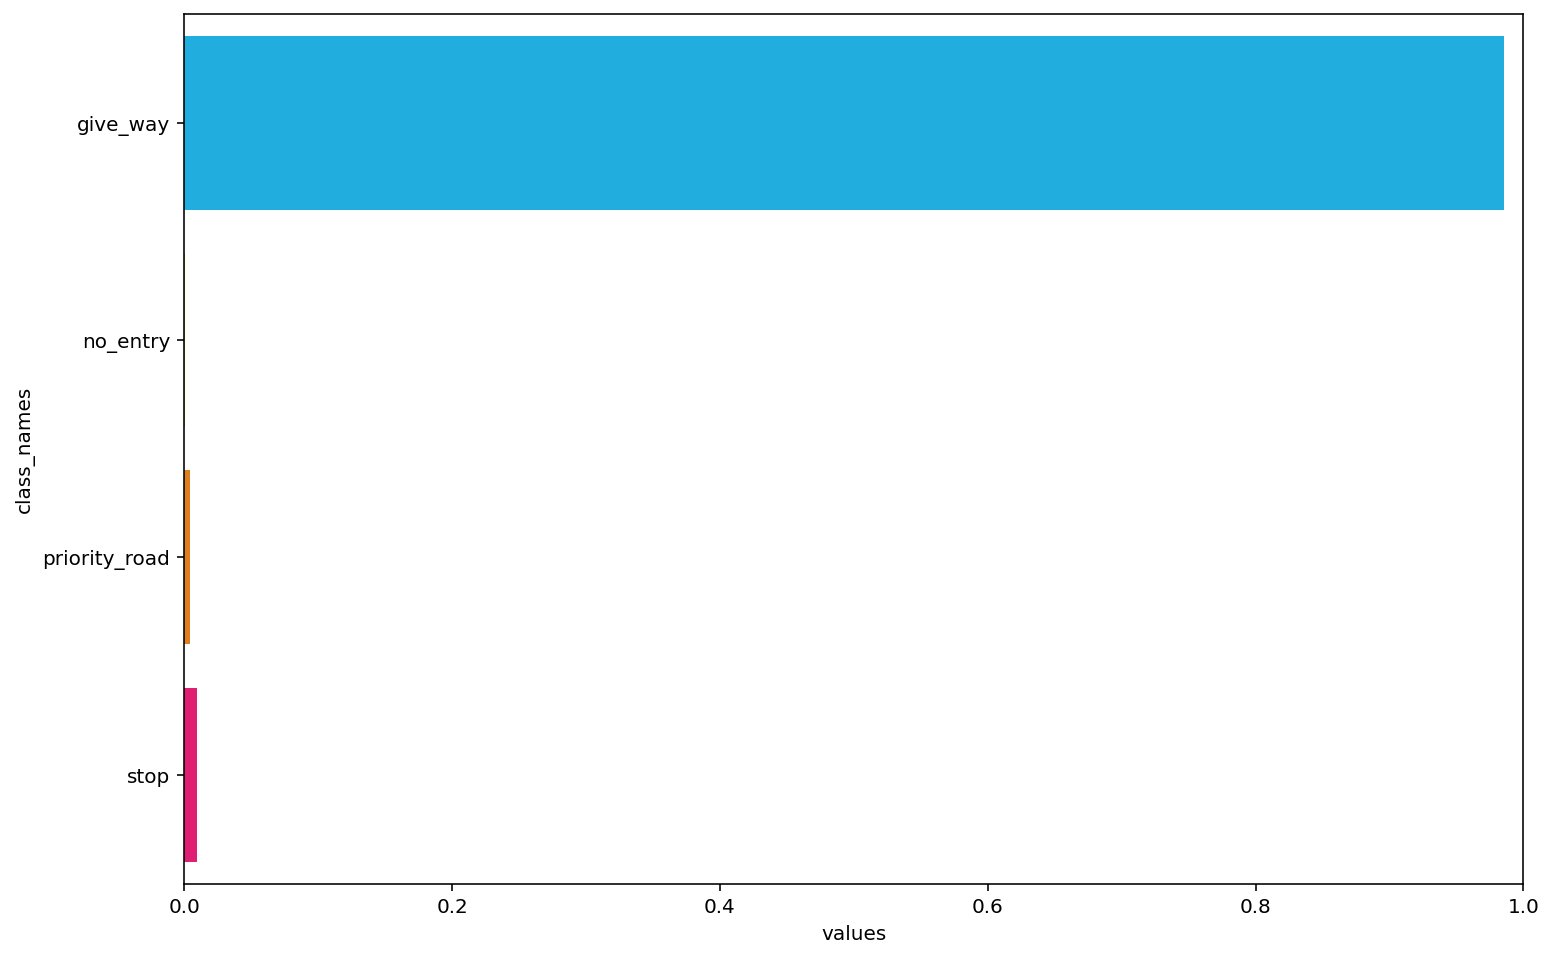

In [54]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

### It is super confident in being wrong, it thinks that sign is 95% give way sign, need to handle this by detecting misclassified signs

In [55]:
unknown_indices = [
    i for i, f in enumerate(train_folders) if i not in class_indices
]
len(unknown_indices)

39

In [57]:
for ds in DATASETS:
    (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)
    
for ui in unknown_indices:
    image_paths = np.array(glob(f'{train_folders[ui]}/*ppm'))
    image_paths = np.random.choice(image_paths, 50)
    
    ds_split = np.split(image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))])
    dataset_data = zip(DATASETS, ds_split)
    
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')
            
    

In [58]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
    for d in DATASETS
}

In [59]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}

In [60]:
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 5693, 'val': 783, 'test': 792}

In [61]:
%%time

enhanced_model = create_model(len(class_names))
enhanced_model, history = train_model(enhanced_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.41047161878243593 accuracy 0.8603548217108731
Val loss 0.01829944211411722 accuracy 0.9910600255427843

Best val accuracy: 0.9910600255427843
Epoch 2/3
----------
Train loss 0.15743804428977579 accuracy 0.9501141753030037
Val loss 0.01080587151509648 accuracy 0.9974457215836526

Best val accuracy: 0.9974457215836526
Epoch 3/3
----------
Train loss 0.11486671948700808 accuracy 0.9671526435974004
Val loss 0.013314952655714385 accuracy 0.9974457215836526

Best val accuracy: 0.9974457215836526
CPU times: user 4min 12s, sys: 7.97 s, total: 4min 20s
Wall time: 4min 24s


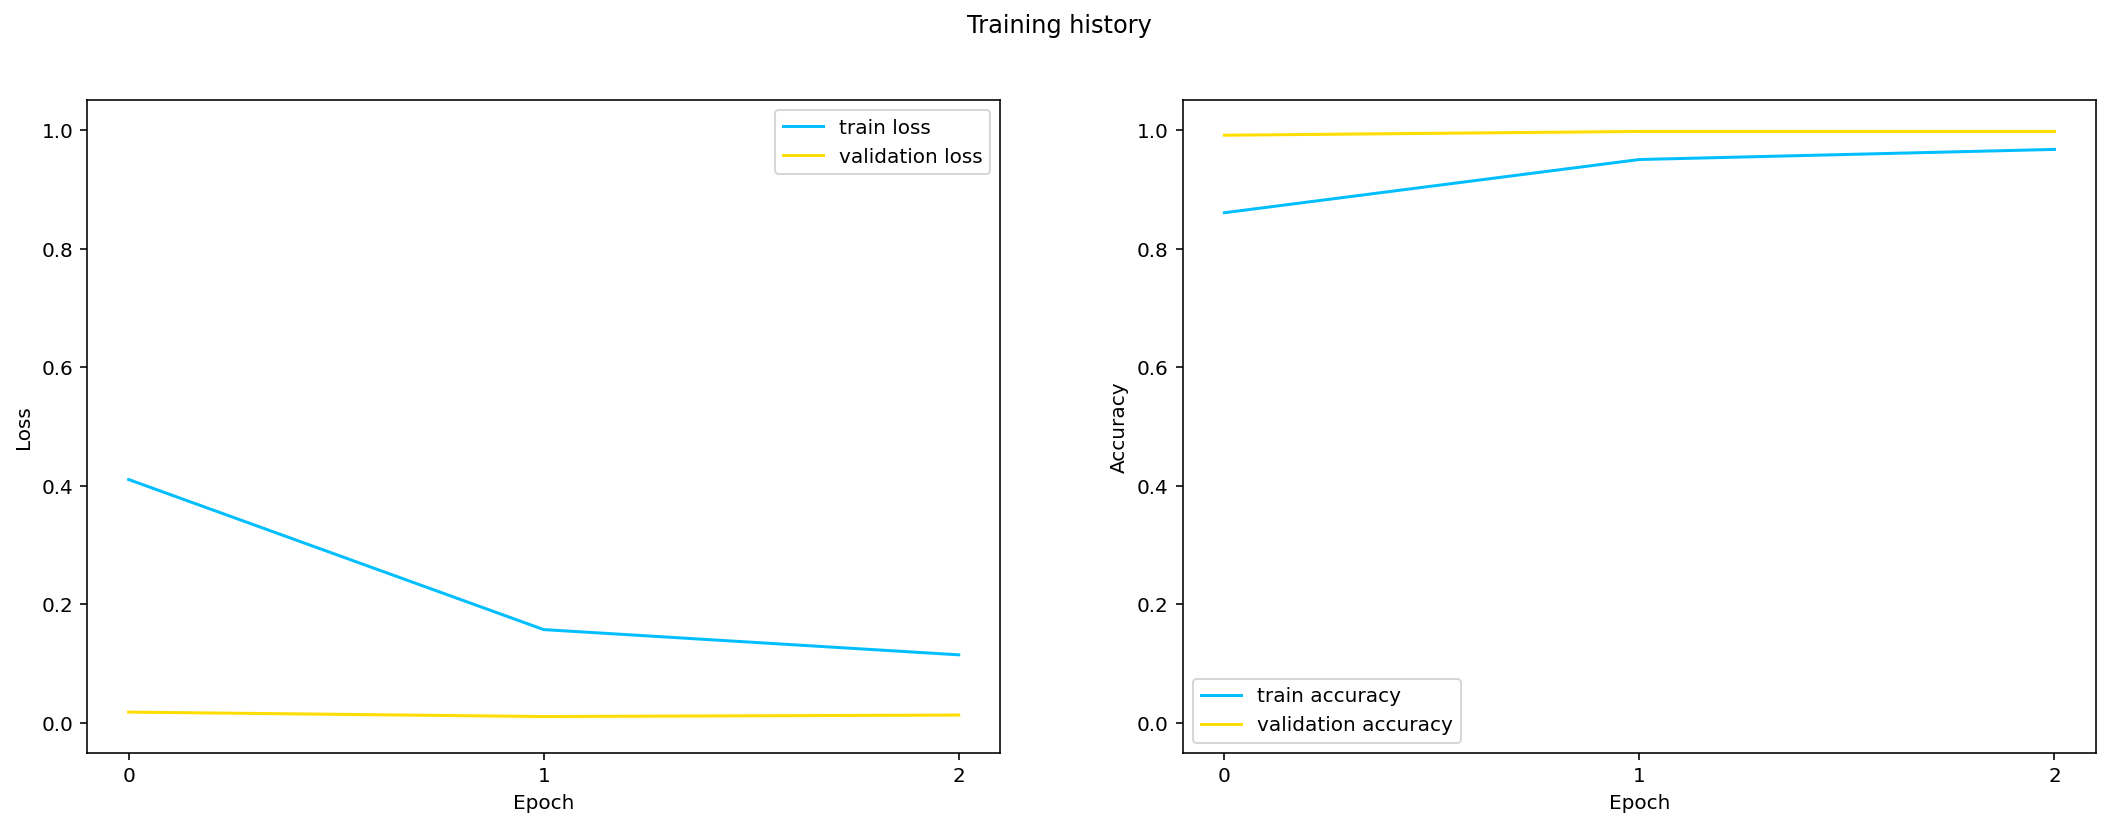

In [62]:
plot_training_history(history)

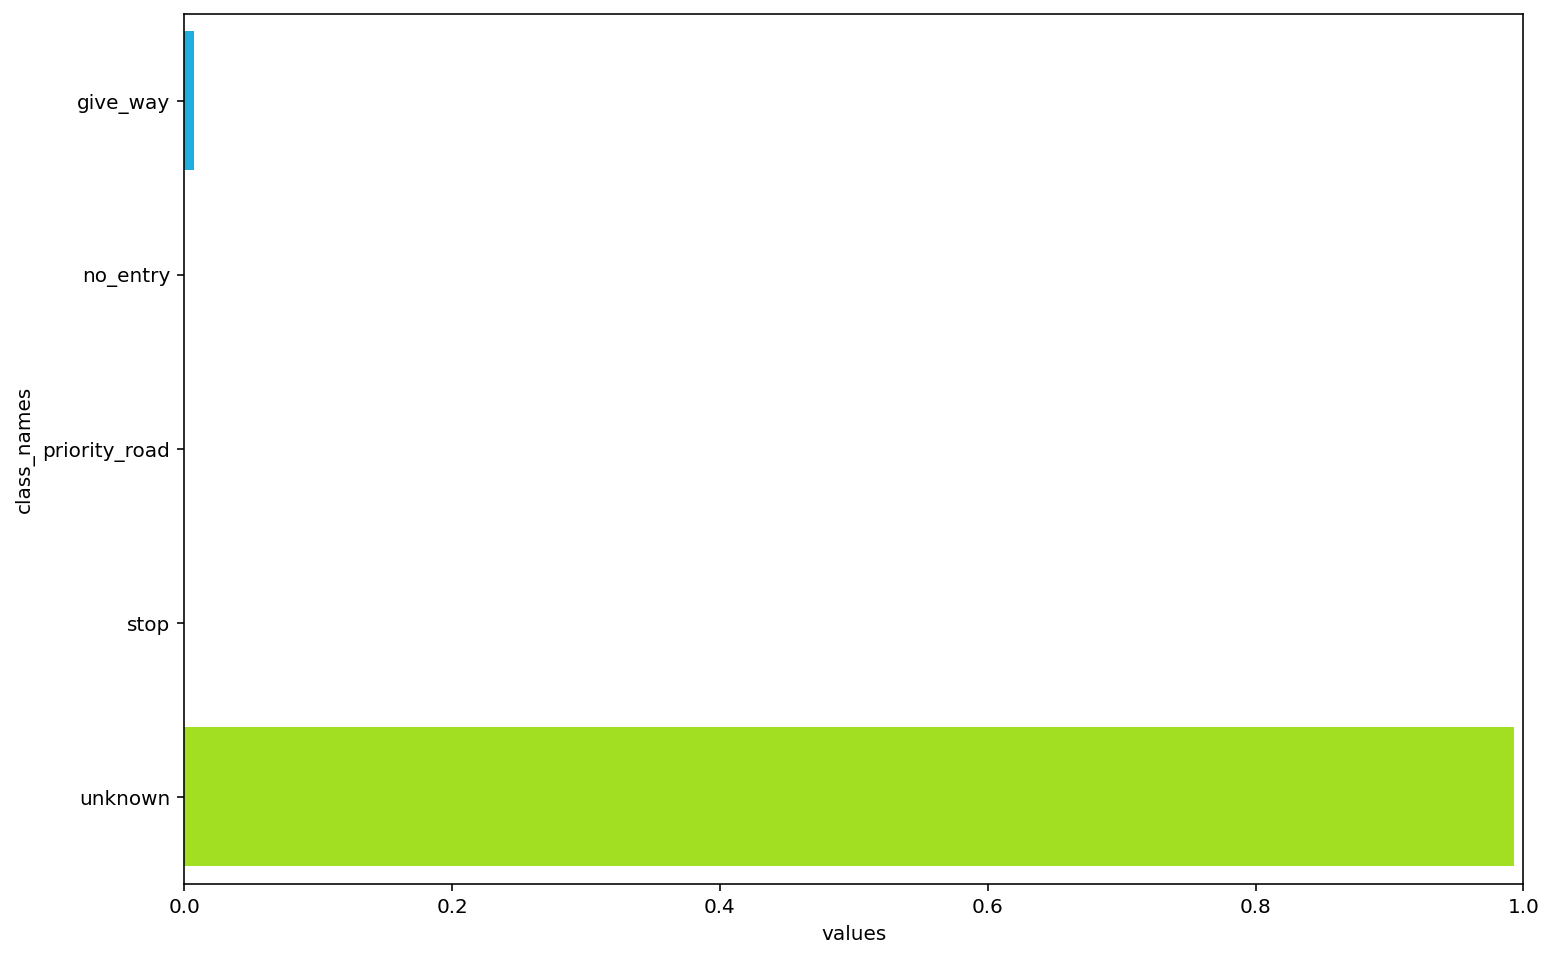

In [63]:
pred = predict_proba(enhanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

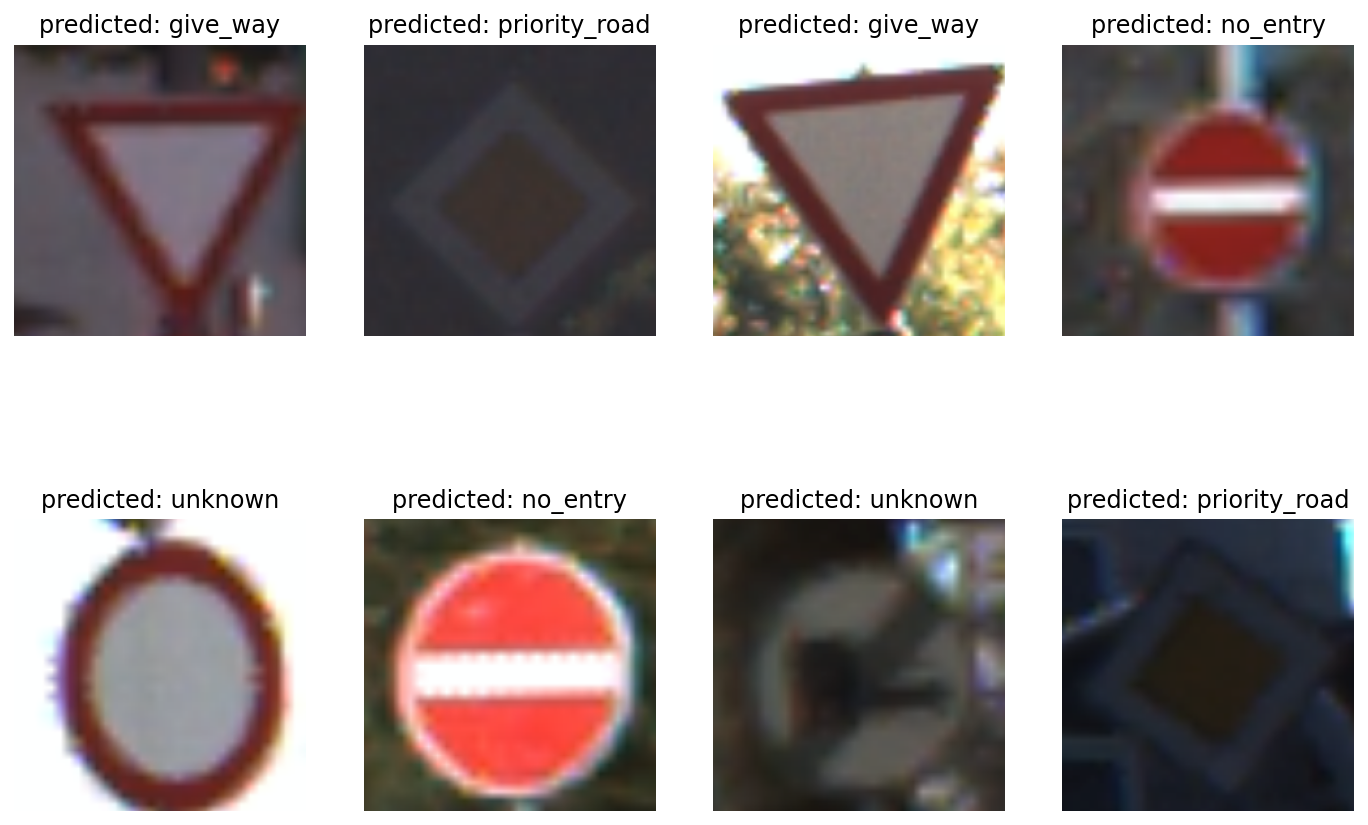

In [64]:
show_predictions(enhanced_model, class_names, n_images=8)

In [66]:
y_pred, y_test = get_predictions(enhanced_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78
      unknown       1.00      1.00      1.00       177

     accuracy                           1.00       792
    macro avg       1.00      1.00      1.00       792
 weighted avg       1.00      1.00      1.00       792

